In [86]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.spatial import distance_matrix

number_cities = 40
x_max         = 100000    # maximum coordinates of a city on the x axis
y_max         = 100000    # maximum coordinates of a city on the y axis

coords        = np.random.randint([x_max, y_max], size=(number_cities, 2))  # Creation of a random matrix of city coordinates

print(coords)

[[14200 18418]
 [ 3731 34146]
 [42582   456]
 [46725  3049]
 [28656 42199]
 [98325 58536]
 [97179 40754]
 [  671 88152]
 [20403 36674]
 [18101 17940]
 [ 8108 72685]
 [10955 26877]
 [34610 82604]
 [41521 57902]
 [80248 66480]
 [32596 85289]
 [76305 97151]
 [ 7837 31624]
 [44477  1243]
 [81853 78826]
 [64474 22090]
 [26061 19536]
 [94903   745]
 [77169 38816]
 [59548 73500]
 [38556 82329]
 [35711  7698]
 [56943 88268]
 [77511 61500]
 [82820 26883]
 [28316 64774]
 [65866 67167]
 [ 3015 60500]
 [33315  5929]
 [18600 54631]
 [ 3660  7819]
 [65396 15219]
 [90712  3883]
 [86349 41451]
 [88927 38289]]


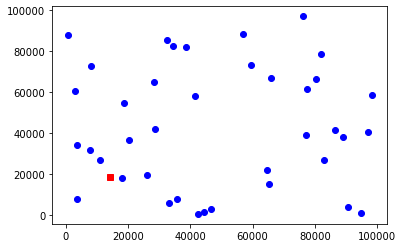

In [87]:
x, y = coords.T                             # We define that the first value of coords is X and the second is Y
plt.plot(x[0], y[0], c='r', marker='s')
plt.scatter(x[1:],y[1:], c='b')             # Put the x and y axis in pyplot
plt.show()                                  # Display the coordinates of the cities on an orthonormal coordinate system

In [88]:

'''
Generate city names in alphabetical order
'''
cities = []

for i in range(number_cities):
    city = chr(ord('A') + i)
    cities.append(city)

'''
Creation of the matrix of distances between cities
'''

df       = pd.DataFrame(coords, columns=['xcord', 'ycord'],    index=cities)
matrix   = distance_matrix(df.values, df.values)
distance = pd.DataFrame(matrix, index=df.index, columns=df.index)

print(df)
print(distance)

   xcord  ycord
A  14200  18418
B   3731  34146
C  42582    456
D  46725   3049
E  28656  42199
F  98325  58536
G  97179  40754
H    671  88152
I  20403  36674
J  18101  17940
K   8108  72685
L  10955  26877
M  34610  82604
N  41521  57902
O  80248  66480
P  32596  85289
Q  76305  97151
R   7837  31624
S  44477   1243
T  81853  78826
U  64474  22090
V  26061  19536
W  94903    745
X  77169  38816
Y  59548  73500
Z  38556  82329
[  35711   7698
\  56943  88268
]  77511  61500
^  82820  26883
_  28316  64774
`  65866  67167
a   3015  60500
b  33315   5929
c  18600  54631
d   3660   7819
e  65396  15219
f  90712   3883
g  86349  41451
h  88927  38289
               A             B              C             D             E  \
A       0.000000  18893.648271   33588.262355  35973.348273  27830.053845   
B   18893.648271      0.000000   51423.888427  53061.355476  26193.633463   
C   33588.262355  51423.888427       0.000000   4887.545192  44004.676172   
D   35973.348273  53061.355476    48

In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from time import time


class VPR:

    def __init__(self, n_trucks, dimension, capacity, demands, adj_matrix):
        self.n_trucks = n_trucks
        self.dimension = dimension
        self.capacity = capacity
        self.demands = demands
        self.adj_matrix = adj_matrix
        self.adj_matrix_sum = adj_matrix.sum()
        self.final_cost = self.adj_matrix_sum
        self.final_sol = None

        self.epochs = None
        self.n_ants = None
        self.alpha = None
        self.beta = None
        self.rho = None
        self.init_pheromone_value = None
        self.pheromone_map = None
        self.raw_prob_matrix = None
        self.tabu = None
        self.tabu_sum = None
        self.capacity_left = None

    def get_probality(self, raw_prob_list):
        prob_list = raw_prob_list/raw_prob_list.sum()
        return prob_list

    def get_next_vertex(self, pos):
        potential = deepcopy(self.tabu)
        potential_sum = self.tabu_sum
        while potential_sum < self.dimension:
            raw_prob_list = deepcopy(self.raw_prob_matrix[pos]) * potential
            next_vertex = np.random.choice(np.arange(0, self.dimension), p=self.get_probality(raw_prob_list))
            if self.demands[next_vertex] <= self.capacity_left:
                return next_vertex
            potential[next_vertex] = 0
            potential_sum += 1
        return 0

    def local_update(self, i, j):
        self.pheromone_map[i, j] += self.rho * self.init_pheromone_value / self.adj_matrix[i, j]
        self.pheromone_map[j, i] = self.pheromone_map[i, j]
        self.raw_prob_matrix[i, j] = self.raw_prob_matrix[j, i] = (self.pheromone_map[i, j] ** self.alpha) * \
                                                                  ((1 / self.adj_matrix[i, j]) ** self.beta)

    def global_update(self, best_solution, best_cost):
        for one_path in best_solution:
            for i in range(len(one_path)-1):
                self.pheromone_map[one_path[i], one_path[i + 1]] += self.rho * self.capacity / best_cost
                self.pheromone_map[one_path[i + 1], one_path[i]] = self.pheromone_map[one_path[i], one_path[i + 1]]
                self.raw_prob_matrix[one_path[i], one_path[i + 1]] = \
                    self.raw_prob_matrix[one_path[i + 1], one_path[i]] = \
                    (self.pheromone_map[one_path[i], one_path[i + 1]] ** self.alpha) * \
                    ((1 / self.adj_matrix[one_path[i], one_path[i + 1]]) ** self.beta)

    def get_cost(self, solution):
        current_cost = 0
        for i in range(len(solution) - 1):
            current_cost += self.adj_matrix[solution[i], solution[i + 1]]
        return current_cost

    def plot_function(self):
        box = {'facecolor': 'white',
               'edgecolor': 'black',
               'boxstyle': 'round'}
        plt.figure(figsize=(9.5, 6))
        plt.text(self.epochs - 18, self.show_epoch[4] - 60,
                 f'cost={round(self.final_cost, 2)}, \n'
                 f'epochs={self.epochs}, \n'
                 f'n_ants={self.n_ants}, \n'
                 f'alpha={self.alpha}, \n'
                 f'beta={self.beta}, \n'
                 f'p={self.rho}, \n'
                 f'init_ph={self.init_pheromone_value}',
                 bbox=box, color='black', fontsize=12)
        plt.plot(np.arange(self.epochs), self.show_cost, 'r')
        plt.plot(np.arange(self.epochs), self.show_epoch, 'k')
        plt.grid()
        plt.title(f'Fitness function for A-n{self.dimension}-k{self.n_trucks}', fontsize=18)
        plt.xlabel('epoch')
        plt.ylabel('cost')
        plt.show()

    def compute(self, epochs=100, n_ants=50, alpha=1.5, beta=0.3, rho=0.95, init_pheromone=1000):
        self.epochs = epochs
        self.n_ants = n_ants
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.init_pheromone_value = init_pheromone
        self.pheromone_map = np.full(shape=(self.dimension, self.dimension), fill_value=self.init_pheromone_value)
        np.fill_diagonal(self.pheromone_map, 0)

        np.fill_diagonal(self.adj_matrix, 0.1)
        self.raw_prob_matrix = (self.pheromone_map ** self.alpha) * ((1 / self.adj_matrix) ** self.beta)
        np.fill_diagonal(self.adj_matrix, 0)

        self.show_epoch = []
        self.show_cost = []
        for epoch in range(self.epochs):
            time_s = time()
            best_solution = None
            best_cost = self.adj_matrix_sum
            for ant in range(self.n_ants):
                current_state = 0
                solutions = []
                one_path_solution = [0]
                self.capacity_left = self.capacity
                self.tabu = np.ones(self.dimension)
                self.tabu[0] = 0
                self.tabu_sum = 1
                while self.tabu_sum < self.dimension:
                    next_state = self.get_next_vertex(current_state)
                    if next_state == 0:
                        one_path_solution.append(0)
                        solutions.append(one_path_solution)
                        one_path_solution = [0]
                        current_state = 0
                        self.capacity_left = self.capacity
                        continue
                    one_path_solution.append(next_state)
                    self.capacity_left -= self.demands[next_state]
                    self.local_update(current_state, next_state)
                    current_state = next_state
                    self.tabu[current_state] = 0
                    self.tabu_sum += 1

                one_path_solution.append(0)
                solutions.append(one_path_solution)
                cost = sum([self.get_cost(sol) for sol in solutions])

                assert all(np.unique(np.hstack(solutions)) == np.arange(self.dimension))

                if cost < best_cost:
                    best_cost = cost
                    best_solution = solutions

            self.global_update(best_solution, best_cost)
            self.show_epoch.append(best_cost)
            if self.final_cost > best_cost:
                self.final_cost = best_cost
                self.final_sol = best_solution
                self.show_cost.append(self.final_cost)
            else:
                self.show_cost.append(self.show_cost[-1])
            # print(f'Epoch: {epoch} | time: {round(time() - time_s, 4)}| best cost: {best_cost}')

        self.final_sol = [(np.array(x) + 1).tolist() for x in self.final_sol]

In [118]:
car_number                       =  1
distance_ant                     =  matrix
distance_ant[distance_ant == 0]  =  np.inf

capacity                         =  100
dimension                        =  number_cities
asj_matrix                       =  coords
demands                          =  [10 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,10,
                                     10 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,10,
                                     10 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,10 ,10,
                                     10 ,10 ,10 ,10 ,10 ,10 ,10, 10, 10, 10]

adj_matrix                       =  matrix

case = VPR(car_number, dimension, capacity, demands, adj_matrix)
case.compute(epochs=1000, n_ants=100, alpha=1, beta=1, rho=0.95, init_pheromone=1000)

print(f'Found solution:')
test534 = case.final_sol
display(case.final_sol)

Found solution:


[[1, 2, 8, 15, 40, 7, 6, 20, 29, 32, 17, 1],
 [1, 34, 27, 22, 5, 10, 18, 36, 3, 19, 4, 1],
 [1, 35, 33, 11, 26, 14, 16, 31, 28, 25, 13, 1],
 [1, 12, 9, 38, 23, 37, 21, 30, 39, 24, 1]]

Couple :  0 1
Couple :  1 7
Couple :  7 14
Couple :  14 39
Couple :  39 6
Couple :  6 5
Couple :  5 19
Couple :  19 28
Couple :  28 31
Couple :  31 16
Couple :  16 0
---------------------
Couple :  0 33
Couple :  33 26
Couple :  26 21
Couple :  21 4
Couple :  4 9
Couple :  9 17
Couple :  17 35
Couple :  35 2
Couple :  2 18
Couple :  18 3
Couple :  3 0
---------------------
Couple :  0 34
Couple :  34 32
Couple :  32 10
Couple :  10 25
Couple :  25 13
Couple :  13 15
Couple :  15 30
Couple :  30 27
Couple :  27 24
Couple :  24 12
Couple :  12 0
---------------------
Couple :  0 11
Couple :  11 8
Couple :  8 37
Couple :  37 22
Couple :  22 36
Couple :  36 20
Couple :  20 29
Couple :  29 38
Couple :  38 23
Couple :  23 0
---------------------


<function matplotlib.pyplot.show(close=None, block=None)>

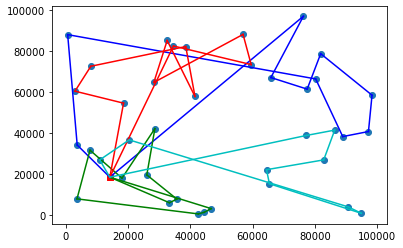

In [119]:
plt.scatter(x[0], y[0], c='r', marker='s')
plt.scatter(x[1:], y[1:])
col = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
i   = 0
  
for truck in test534:
    for test in range(len(truck)-1):
        dot1 = truck[test]-1
        dot2 = truck[test+1]-1
        print("Couple : ", dot1, dot2)
        plt.plot([x[dot1], x[dot2]], [y[dot1], y[dot2]], c=col[(i) % len(col)])
    i += 1
    print("---------------------")
plt.show

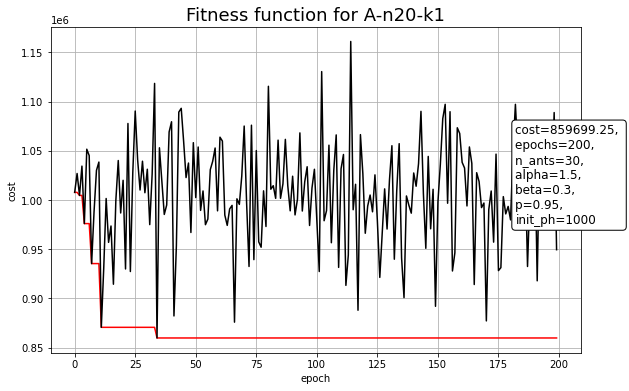

In [29]:
case.plot_function()